# TDA

Trying out correlations analysis from the TDA toolbox.

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns
import gudhi

In [2]:
import os
import pickle

In [3]:
DATA_FOLDER = '../data'
PICKLE_FOLDER = '../pickles'

In [4]:
df = pd.read_csv(f'{DATA_FOLDER}/patients-cleaned.csv', index_col=0)

In [5]:
df.head()

,age,sex,target
0,24.750,1,0
1,27.667,1,0
2,34.167,1,0
3,28.917,1,0
4,31.917,0,0


In [6]:
print('Samples: ', df.shape[0])

Samples:  190


In [7]:
with open(f'{PICKLE_FOLDER}/test-indices.pickle', 'rb') as f:
    test_indices = pickle.load(f)

train_indices = list(set(range(df.shape[0])) - set(test_indices))

In [8]:
df = df.iloc[train_indices].reset_index(drop=True)

In [9]:
y_train = df['target'].values

In [10]:
with open(f'{PICKLE_FOLDER}/fc-pearson.pickle', 'rb') as f:
    fc_pearson = pickle.load(f)

with open(f'{PICKLE_FOLDER}/fc-spearman.pickle', 'rb') as f:
    fc_spearman = pickle.load(f)

with open(f'{PICKLE_FOLDER}/fc-partial-pearson.pickle', 'rb') as f:
    fc_partial_pearson = pickle.load(f)

fc_pearson = fc_pearson[train_indices]
fc_spearman = fc_spearman[train_indices]
fc_partial_pearson = fc_partial_pearson[train_indices]

In [11]:
target_index_change = 65    # Observe `df`.
subjects, brain_regions, _ = fc_pearson.shape

print('Samples: ', subjects)
print('Features: ', brain_regions)
print('Index where target feature changes: ', target_index_change)

Samples:  140
Features:  90
Index where target feature changes:  65


## Rips filtration

In [12]:
fc = fc_pearson.copy()

avg_fc_control = np.mean(fc[0:target_index_change], axis=0)
avg_fc_patient = np.mean(fc[target_index_change:], axis=0)
avg_fc_diff = avg_fc_control - avg_fc_patient

In [13]:
rips_complex_control = gudhi.RipsComplex(
    distance_matrix=1-np.abs(avg_fc_control),
    max_edge_length=1.0
)
simplex_tree_control = rips_complex_control.create_simplex_tree(max_dimension=4)

In [14]:
rips_complex_patient = gudhi.RipsComplex(
    distance_matrix=1-np.abs(avg_fc_patient),
    max_edge_length=1.0
)
simplex_tree_patient = rips_complex_patient.create_simplex_tree(max_dimension=4)

In [15]:
rips_complex_diff = gudhi.RipsComplex(
    distance_matrix=1-np.abs(avg_fc_diff),
    max_edge_length=1.0
)
simplex_tree_diff = rips_complex_diff.create_simplex_tree(max_dimension=4)

In [16]:
# Compute filtations.
diag_control = simplex_tree_control.persistence(min_persistence=0.05)
diag_patient = simplex_tree_patient.persistence(min_persistence=0.05)
diag_diff = simplex_tree_diff.persistence(min_persistence=0.05)

### Barcodes

usetex mode requires ghostscript.


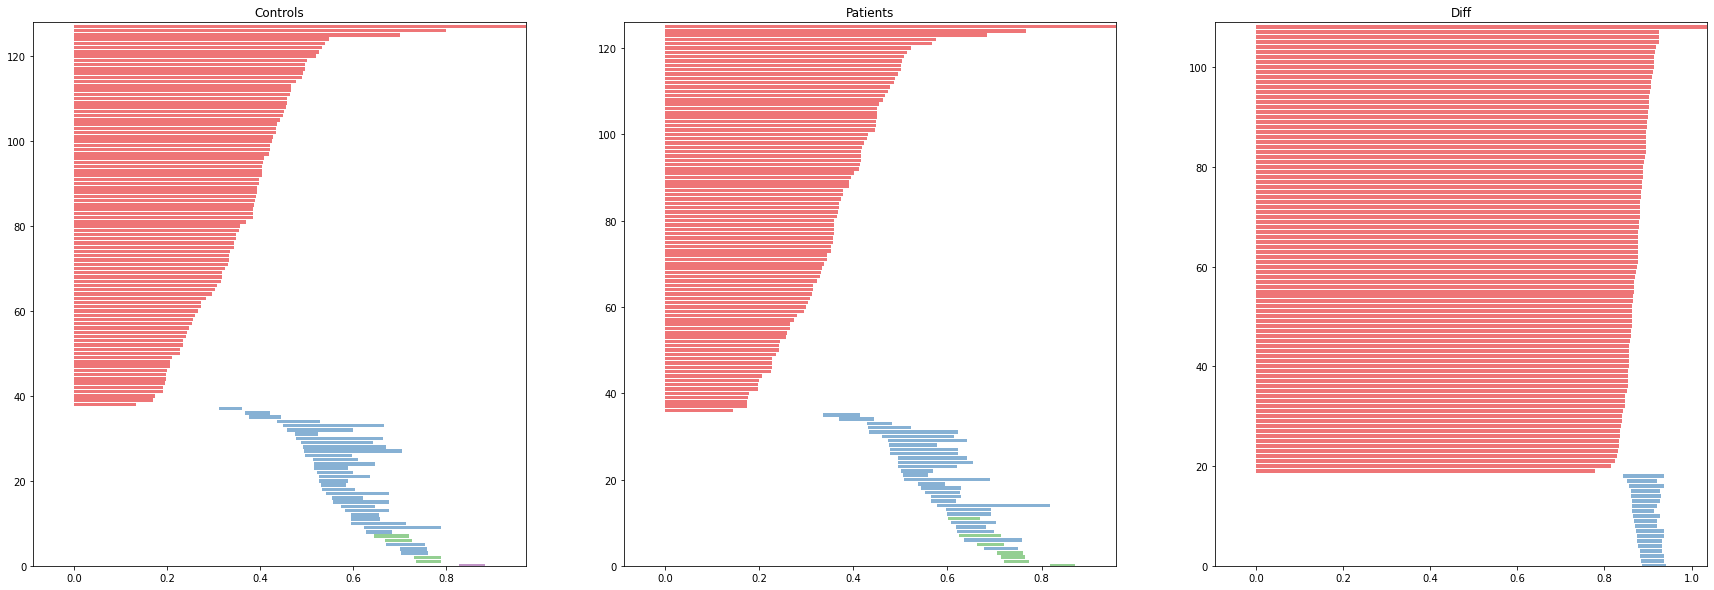

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(30, 10))

gudhi.plot_persistence_barcode(diag_control, axes=ax[0])
gudhi.plot_persistence_barcode(diag_patient, axes=ax[1])
gudhi.plot_persistence_barcode(diag_diff, axes=ax[2])

ax[0].set_title('Controls')
ax[1].set_title('Patients')
ax[2].set_title('Diff')

plt.show()

### Persistence diagrams

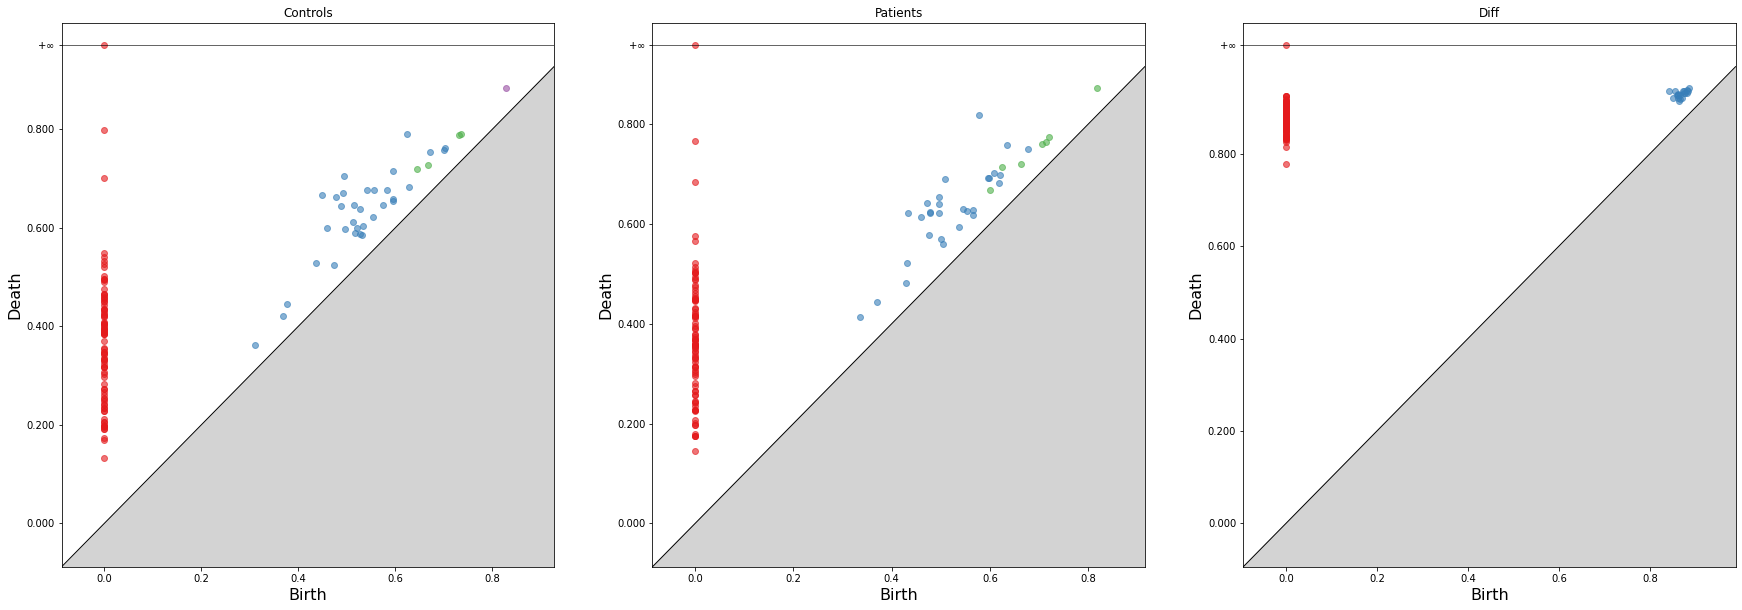

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(30, 10))

gudhi.plot_persistence_diagram(diag_control, axes=ax[0])
gudhi.plot_persistence_diagram(diag_patient, axes=ax[1])
gudhi.plot_persistence_diagram(diag_diff, axes=ax[2])

ax[0].set_title('Controls')
ax[1].set_title('Patients')
ax[2].set_title('Diff')

plt.show()

### Bottleneck distances

In [19]:
print('Control to patient')
gudhi.bottleneck_distance([d[1] for d in diag_control], [d[1] for d in diag_patient])

Control to patient


0.04703266720305588

In [20]:
print('Control to diff')
gudhi.bottleneck_distance([d[1] for d in diag_control], [d[1] for d in diag_diff])

Control to diff


0.44775121181071764

In [21]:
print('Patient to diff')
gudhi.bottleneck_distance([d[1] for d in diag_patient], [d[1] for d in diag_diff])

Patient to diff


0.44676000704522056

## Prepare filtration data

In [22]:
fc = fc_pearson.copy()

In [43]:
X_train = []

for i, fc_sample in enumerate(fc):
    # Define complex.
    rc = gudhi.RipsComplex(
        distance_matrix=1-np.abs(fc_sample),
        max_edge_length=1.0
    ).create_simplex_tree(max_dimension=2)

    # Compute filtration.
    diag = rc.persistence(min_persistence=0.05)
    # Remove dimensions.
    raw_diag = [d[1] for d in diag if d[1][1] != np.inf]

    X_train.append(np.array(raw_diag))

    if (i+1) % 10 == 0:
        print(i+1)

10
20
30
40
50
60
70
80
90
100
110
120
130
140


## Modelling

In [45]:
# Imports.
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Models.
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

import gudhi.representations

In [46]:
pipe = Pipeline([
    ("Separator", gudhi.representations.DiagramSelector(limit=np.inf, point_type="finite")),
    ("TDA", gudhi.representations.PersistenceImage()),
    ("Estimator", SVC())
])

In [59]:
param = [
    {
        "TDA":                 [gudhi.representations.PersistenceWeightedGaussianKernel()], 
        "TDA__bandwidth":      [1, 0.5, 0.1, 0.01, 0.001],
        "TDA__weight":         [lambda x: 1, lambda x: np.arctan(np.abs(x[1])-np.abs(x[0]))], 
        "Estimator":           [
            SVC(kernel="precomputed", gamma="auto", C=0.1), 
            SVC(kernel="precomputed", gamma="auto", C=1), 
            SVC(kernel="precomputed", gamma="auto", C=10),
            SVC(kernel="precomputed", gamma="auto", C=100)
        ]
    }
]

# lambda x: np.arctan(x[1]-x[0]), 

In [60]:
model = GridSearchCV(pipe, param, cv=3)

In [61]:
model.fit(X_train, y_train)


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('Separator', DiagramSelector()),
                                       ('TDA', PersistenceImage()),
                                       ('Estimator', SVC())]),
             param_grid=[{'Estimator': [SVC(C=0.1, gamma='auto',
                                            kernel='precomputed'),
                                        SVC(C=1, gamma='auto',
                                            kernel='precomputed'),
                                        SVC(C=10, gamma='auto',
                                            kernel='precomputed'),
                                        SVC(C=100, gamma='auto',
                                            kernel='precomputed')],
                          'TDA': [PersistenceWeightedGaussianKernel(bandwidth=0.1,
                                                                    weight=<function <lambda> at 0x0000022AA79078B8>)],
                          'TDA__bandwidth': [1, 

In [62]:
print(model.best_params_)


{'Estimator': SVC(C=0.1, gamma='auto', kernel='precomputed'), 'TDA': PersistenceWeightedGaussianKernel(bandwidth=0.1,
                                  weight=<function <lambda> at 0x0000022AA79078B8>), 'TDA__bandwidth': 0.1, 'TDA__weight': <function <lambda> at 0x0000022AA79078B8>}


In [63]:
print("Train accuracy = " + str(model.score(X_train, y_train)))

Train accuracy = 0.6428571428571429
